# Setup imports


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import CIFAR10

import torchvision
import matplotlib.pyplot as plt
from torchvision.datasets import *
from torchvision.transforms import *
from tqdm.auto import tqdm

from torchvision.models import wide_resnet50_2
from torchvision.models import resnet152

import torch.nn.functional as F


# Import Art Dataset from ArtBench

In [ ]:
# dataset taken from ArtBench Github
@article{liao2022artbench,
  title={The ArtBench Dataset: Benchmarking Generative Models with Artworks},
  author={Liao, Peiyuan and Li, Xiuyu and Liu, Xihui and Keutzer, Kurt},
  journal={arXiv preprint arXiv:2206.11404},
  year={2022}
}

In [ ]:
class ArtBench10(CIFAR10):

    base_folder = "artbench-10-batches-py"
    url = "https://artbench.eecs.berkeley.edu/files/artbench-10-python.tar.gz"
    filename = "artbench-10-python.tar.gz"
    tgz_md5 = "9df1e998ee026aae36ec60ca7b44960e"
    train_list = [
        ["data_batch_1", "c2e02a78dcea81fe6fead5f1540e542f"],
        ["data_batch_2", "1102a4dcf41d4dd63e20c10691193448"],
        ["data_batch_3", "177fc43579af15ecc80eb506953ec26f"],
        ["data_batch_4", "566b2a02ccfbafa026fbb2bcec856ff6"],
        ["data_batch_5", "faa6a572469542010a1c8a2a9a7bf436"],
    ]

    test_list = [
        ["test_batch", "fa44530c8b8158467e00899609c19e52"],
    ]
    meta = {
        "filename": "meta",
        "key": "styles",
        "md5": "5bdcafa7398aa6b75d569baaec5cd4aa",
    }

# Dataset

Load the dataset

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load Data
image_size = 32
batch_size = 64
transforms = {
    "visualize":
        ToTensor(),
    "train": Compose([
        RandomCrop(image_size, padding=4),
        RandomHorizontalFlip(),
        ToTensor(),
        #Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]),
    "test": ToTensor(),
}

Visualize Data

100%|██████████| 172959801/172959801 [00:04<00:00, 36352629.48it/s]


Extracting ./data/artbench-10-python.tar.gz to ./data


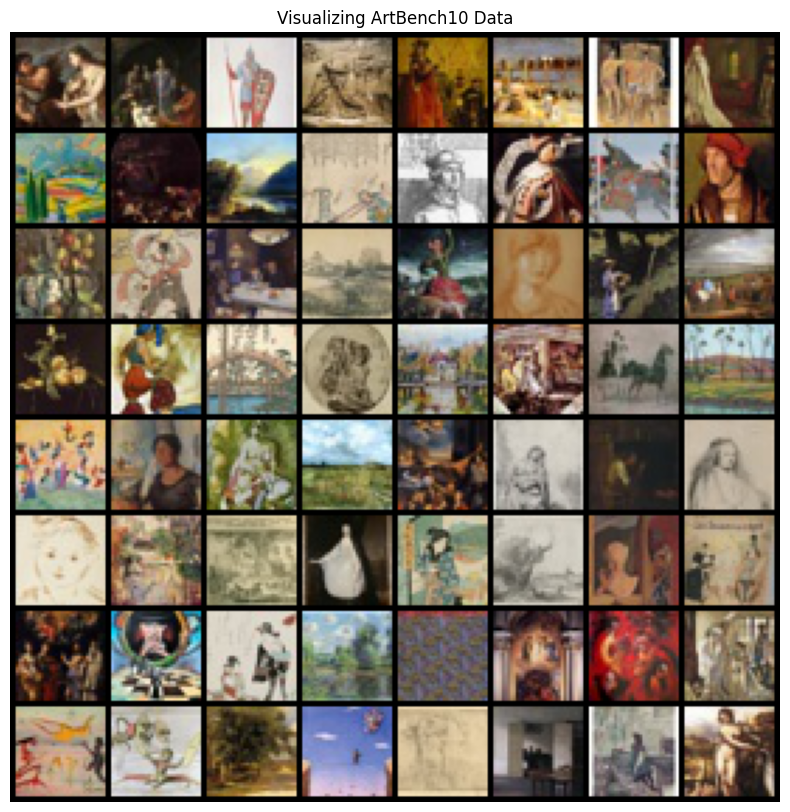

In [ ]:
#visualize raw data
visualize_dataset = ArtBench10(root='./data', train=True, download=True, transform=transforms['visualize'])
visualizer = DataLoader(dataset=visualize_dataset, batch_size=batch_size, shuffle=True)

# Get a batch of training data
images, labels = next(iter(visualizer))

# Create a grid from the images
img_grid = torchvision.utils.make_grid(images)

# Convert the grid to a numpy image
img_grid_np = img_grid.numpy().transpose((1, 2, 0))

# Visualize the images
plt.figure(figsize=(10,10))
plt.imshow(img_grid_np)
plt.title('Visualizing ArtBench10 Data')
plt.axis('off')
plt.show()

# Setup values

In [ ]:
LR                  = 0.1
BATCH_SIZE          = 128
EPOCHS              = 170

LAYERS              = 28        # total number of layers (default: 28)
WIDE                = 10        # widen factor (default: 10)
BATCHNORM           = True      # apply BatchNorm
FIXUP               = True      # apply Fixup
DROPOUT             = 0.3         # dropout probability (default: 0.0)

AUGMENT             = True      # use standard augmentation (default: True)
CUTOUT              = True     # apply cutout
N_HOLES             = 1         # number of holes to cut out from image
LENGTH              = 5        # length of the holes

# Image Setup
CLASS_NUM          = 10
IMG_ROWS, IMG_COLS = 32, 32
IMG_CHANNELS       = 3
IMG_MEAN           = [0.5161, 0.4643, 0.3974]
IMG_STD            = [0.2518, 0.2457, 0.2425]

# Setup SGD
momentum = 0.9
nesterov = True
weight_decay = 5e-4
start_epoch = 0


In [ ]:
import numpy as np
# Random seed
RANDOM_SEED        = 42
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# tmp
best_acc = 0
lr_tmp = 0

# Create and Run CNN

In [ ]:
"""
Wide ResNet by Sergey Zagoruyko and Nikos Komodakis
Fixup initialization by Hongyi Zhang, Yann N. Dauphin, Tengyu Ma
Based on code by xternalz and Andy Brock:
https://github.com/xternalz/WideResNet-pytorch
https://github.com/ajbrock/BoilerPlate
"""
import math

class BasicBlock(nn.Module):
    droprate = 0.0
    use_bn = True
    use_fixup = False
    fixup_l = 12

    def __init__(self, in_planes, out_planes, stride):
        super(BasicBlock, self).__init__()

        self.bn1 = nn.BatchNorm2d(in_planes)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)

        self.equalInOut = in_planes == out_planes
        self.conv_res = nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, padding=0, bias=False)
        self.conv_res = not self.equalInOut and self.conv_res or None

        assert self.use_fixup or self.use_bn, "Need to use at least one thing: Fixup or BatchNorm"

        if self.use_fixup:
            self.multiplicator = nn.Parameter(torch.ones(1,1,1,1))
            self.biases = nn.ParameterList([nn.Parameter(torch.zeros(1,1,1,1))] * 4)

            k = self.conv1.kernel_size[0] * self.conv1.kernel_size[1] * self.conv1.out_channels
            self.conv1.weight.data.normal_(0, self.fixup_l ** (-0.5) * math.sqrt(2. / k))
            self.conv2.weight.data.zero_()

            if self.conv_res is not None:
                k = self.conv_res.kernel_size[0] * self.conv_res.kernel_size[1] * self.conv_res.out_channels
                self.conv_res.weight.data.normal_(0, math.sqrt(2. / k))

    def forward(self, x):
        if self.use_bn:
            x_out = self.relu(self.bn1(x))
            out = self.relu(self.bn2(self.conv1(x_out)))
            if self.droprate > 0:
                out = F.dropout(out, p=self.droprate, training=self.training)
            out = self.conv2(out)
        else:
            x_out = self.relu(x + self.biases[0])
            out = self.conv1(x_out) + self.biases[1]
            out = self.relu(out) + self.biases[2]
            if self.droprate > 0:
                out = F.dropout(out, p=self.droprate, training=self.training)
            out = self.multiplicator * self.conv2(out) + self.biases[3]

        if self.equalInOut:
            return torch.add(x, out)

        return torch.add(self.conv_res(x_out), out)


class NetworkBlock(nn.Module):
    def __init__(self, nb_layers, in_planes, out_planes, block, stride):
        super(NetworkBlock, self).__init__()
        self.layer = self._make_layer(block, in_planes, out_planes, nb_layers, stride)

    def _make_layer(self, block, in_planes, out_planes, nb_layers, stride):
        layers = []

        for i in range(int(nb_layers)):
            _in_planes = i == 0 and in_planes or out_planes
            _stride = i == 0 and stride or 1
            layers.append(block(_in_planes, out_planes, _stride))

        return nn.Sequential(*layers)

    def forward(self, x):
        return self.layer(x)

#@registry.Model
class WideResNet(nn.Module):
    def __init__(self, depth, num_classes, widen_factor=1, droprate=0.0, use_bn=True, use_fixup=False):
        super(WideResNet, self).__init__()

        nChannels = [16, 16 * widen_factor, 32 * widen_factor, 64 * widen_factor]

        assert (depth - 4) % 6 == 0, "You need to change the number of layers"
        n = (depth - 4) / 6

        BasicBlock.droprate = droprate
        BasicBlock.use_bn = use_bn
        BasicBlock.fixup_l = n * 3
        BasicBlock.use_fixup = use_fixup
        block = BasicBlock

        self.conv1 = nn.Conv2d(3, nChannels[0], kernel_size=3, stride=1, padding=1, bias=False)

        self.block1 = NetworkBlock(n, nChannels[0], nChannels[1], block, 1)
        self.block2 = NetworkBlock(n, nChannels[1], nChannels[2], block, 2)
        self.block3 = NetworkBlock(n, nChannels[2], nChannels[3], block, 2)

        self.bn1 = nn.BatchNorm2d(nChannels[3])
        self.relu = nn.ReLU(inplace=True)
        self.fc = nn.Linear(nChannels[3], num_classes)
        self.nChannels = nChannels[3]

        #code to save feature maps
        #self.feature_maps1 = None
        #layer before fully connected and before pooling
        self.feature_maps2 = None
        #layer before fully connected and after pooling
        self.feature_maps3 = None

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                k = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / k))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                m.bias.data.zero_()
                if use_fixup:
                    m.weight.data.zero_()

    def forward(self, x):
        out = self.conv1(x)
        out = self.block1(out)
        out = self.block2(out)
        out = self.block3(out)
        #feature map 2 (to stay consistent with prior training)
        self.feature_maps2 = out.clone()
        out = self.relu(self.bn1(out))
        #feature map 3
        self.feature_maps3 = out.clone()
        out = F.avg_pool2d(out, 8)
        out = out.view(-1, self.nChannels)
        return self.fc(out)

In [ ]:
"""
Cutout implementation by Machine Learning Research Group at the University of Guelph:
https://github.com/uoguelph-mlrg/Cutout
"""


class Cutout(object):
    """Randomly mask out one or more patches from an image.
    Args:
        n_holes (int): Number of patches to cut out of each image.
        length (int): The length (in pixels) of each square patch.
    """
    def __init__(self, n_holes, length):
        self.n_holes = n_holes
        self.length = length

    def __call__(self, img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        h = img.size(1)
        w = img.size(2)

        mask = np.ones((h, w), np.float32)

        for n in range(self.n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = np.clip(y - self.length // 2, 0, h)
            y2 = np.clip(y + self.length // 2, 0, h)
            x1 = np.clip(x - self.length // 2, 0, w)
            x2 = np.clip(x + self.length // 2, 0, w)

            mask[y1: y2, x1: x2] = 0.

        mask = torch.from_numpy(mask)
        mask = mask.expand_as(img)
        img = img * mask

        return img

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR divided by 5 at 60th, 120th and 160th epochs"""
    lr_tmp = LR * ((0.2 ** int(epoch >= 50)) * (0.2 ** int(epoch >= 100))* (0.2 ** int(epoch >= 140)))

    for param_group in optimizer.param_groups:
        param_group["lr"] = lr_tmp

In [ ]:
def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))

    return res

In [ ]:
def validate(val_loader, model, criterion, epoch):
    """Perform validation on the validation set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    model.eval()

    end = time.time()
    for i, (input, target) in enumerate(val_loader):
        target = target.cuda()
        input = input.cuda()
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        with torch.no_grad():
            output = model(input_var)
        loss = criterion(output, target_var)

        prec1 = accuracy(output, target, topk=(1,))[0]
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        batch_time.update(time.time() - end)
        end = time.time()

        #if i % print_freq == 0:
        #    print("Test: [{0}/{1}]\t"
        #          "Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
        #          "Loss {loss.val:.4f} ({loss.avg:.4f})\t"
        #          "Prec@1 {top1.val:.3f} ({top1.avg:.3f})".format(
        #              i, len(val_loader), batch_time=batch_time, loss=losses,
        #              top1=top1))

    #print(" * Prec@1 {top1.avg:.3f}".format(top1=top1))
    return top1.avg

In [ ]:
def predict_proba(model, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    all_pred = np.empty((0, CLASS_NUM), float)
    for images, labels in test_loader:
        #images, labels = data
        images = images.to(device)
        outputs = model(Variable(images))
        curr_pred = F.softmax(outputs).data.cpu().numpy()
        all_pred = np.vstack([all_pred, curr_pred])
    return(all_pred)

In [ ]:
def predict(model, test_loader):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    #device = 'cuda'
    all_pred = np.empty((0, CLASS_NUM), float)
    for images, labels in test_loader:
        #images, labels = data
        images = images.to(device)
        outputs = model(Variable(images))
        curr_pred = F.softmax(outputs, dim=1).data.cpu().numpy()
        all_pred = np.vstack([all_pred, curr_pred])

    predictions = np.argmax(all_pred, axis=1)
    return(predictions)

# process data here :to do


Get IMAGE MEAN and STD

In [ ]:
def compute_mean_std():
    trainset = ArtBench10(root='./data', train=True, download=True, transform=ToTensor())
    dataloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=False, num_workers = 4)
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for images, _ in tqdm(dataloader):
        for channel in range(3):
            mean[channel] += images[:, channel, :, :].mean()
            std[channel] += images[:, channel, :, :].std()
    mean.div_(len(dataloader))
    std.div_(len(dataloader))
    return mean, std

IMG_MEAN, IMG_STD = compute_mean_std()
print("Mean: ", IMG_MEAN)
print("STD: ", IMG_STD)

100%|██████████| 172959801/172959801 [00:04<00:00, 36670100.17it/s]


Extracting ./data/artbench-10-python.tar.gz to ./data


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/391 [00:00<?, ?it/s]

Mean:  tensor([0.5161, 0.4643, 0.3974])
STD:  tensor([0.2518, 0.2457, 0.2425])


In [ ]:
IMG_MEAN = IMG_MEAN.numpy().tolist()
IMG_STD = IMG_STD.numpy().tolist()

In [ ]:
print(type(IMG_MEAN))

<class 'list'>


Process Data

In [ ]:
import torch
import torchvision.transforms as transforms
def data_processing (train=True):
    ''' normalize, augmentation and load data in DataLoader'''
    normalize = transforms.Normalize(mean=[x for x in IMG_MEAN],
                                     std=[x for x in IMG_STD])

    # augmentation
    transform_train = transforms.Compose([transforms.ToTensor(),
            transforms.Lambda(lambda x: F.pad(x.unsqueeze(0), (4,4,4,4), mode="reflect").squeeze()),
            transforms.ToPILImage(),
            transforms.RandomCrop(32),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            normalize,
            ])
    if CUTOUT:
        transform_train.transforms.append(Cutout(n_holes=N_HOLES, length=LENGTH))

    transform_test = transforms.Compose([transforms.ToTensor(),normalize])

    # DataLoader
    ### MADE COMPATIBLE WITH ARTBENCH10 DATASET ###
    kwargs = {"num_workers": 2, "pin_memory": True}
    if train:
        #trainset = MyDataset(y_train, x_train, transform=transform_train)
        trainset = ArtBench10(root='./data', train=True, download=True, transform=transform_train)
        train_loader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, **kwargs)
    else:
        #test_set = MyDataset(y_train, x_train, transform=transform_test)
        test_set = ArtBench10(root='./data', train=False, download=True, transform=transform_test)
        train_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE,
                                         shuffle=False, **kwargs)

    return(train_loader)

In [ ]:
train_loader = data_processing(train=True)
test_loader  = data_processing (train=False)
#X_sub_loader = data_processing (X_sub, tmp_y_sub, train=False)

100%|██████████| 172959801/172959801 [00:04<00:00, 41912122.26it/s]


Extracting ./data/artbench-10-python.tar.gz to ./data
Files already downloaded and verified


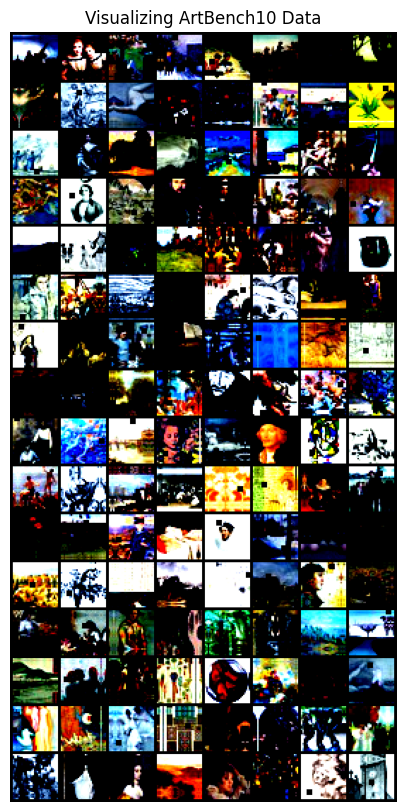

In [ ]:
#visualize raw data
#visualize_dataset = ArtBench10(root='./data', train=True, download=True)
#visualizer = DataLoader(dataset=visualize_dataset, batch_size=batch_size, shuffle=True)


# Get a batch of training data
#images, labels = next(iter(visualizer))
images, labels = next(iter(train_loader))

# Create a grid from the images
img_grid = torchvision.utils.make_grid(images)

# Convert the grid to a numpy image
img_grid_np = img_grid.numpy().transpose((1, 2, 0))

# Visualize the images
plt.figure(figsize=(10,10))
plt.imshow(img_grid_np)
plt.title('Visualizing ArtBench10 Data')
plt.axis('off')
plt.show()

# Setup model

In [ ]:
model = WideResNet(LAYERS, CLASS_NUM, WIDE,
                   droprate=DROPOUT,
                   use_bn=BATCHNORM,
                   use_fixup=FIXUP)

param_num = sum([p.data.nelement() for p in model.parameters()])
print("Number of model parameters:", param_num)

Number of model parameters: 36479218


In [ ]:
import torch.backends.cudnn as cudnn
model = model.cuda()
cudnn.benchmark = True
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(),
                            LR,
                            momentum=momentum,
                            nesterov=nesterov,
                            weight_decay=weight_decay)

In [ ]:

from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
cd feature_maps

/content/drive/.shortcut-targets-by-id/1FuCAqVzBPZ3nIKQQ6hDN995HSNR9pio_/feature_maps


#Train model

In [ ]:
import time

#save feature maps for PCA, etc
connected_list = []

#feature_map_dir = '/content/drive/MyDrive/feature_maps/'
feature_map_dir = '/content/drive/.shortcut-targets-by-id/1FuCAqVzBPZ3nIKQQ6hDN995HSNR9pio_/feature_maps'

def train(train_loader, model, criterion, optimizer, epoch):
    """Train for one epoch on the training set"""
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):
        target = target.cuda()
        input = input.cuda()
        input_var = torch.autograd.Variable(input)
        target_var = torch.autograd.Variable(target)

        output = model(input_var)

        #obtain feature maps during training
        if i == 0 and epoch % 10 == 0:
            print("\nGETTING FEATURE MAPS")
            out = model(input)
            #feature_maps1 = model.feature_maps1.clone()
            #feature_maps1_list.append(feature_maps1)
            feature_maps2 = model.feature_maps2.clone()
            feature_maps3 = model.feature_maps3.clone()

            save_path = f'feature_maps2_epoch_{epoch + 1}.pth'
            full_path2 = feature_map_dir + save_path

            fm2 = {
              'labels': target,
              'feature_map': feature_maps2
            }
            torch.save(checkpoint2, full_path2)

            save_path = f'feature_maps3_epoch_{epoch + 1}.pth'
            full_path3 = feature_map_dir + save_path

            fm3 = {
              'labels': target,
              'feature_map': feature_maps3
            }
            torch.save(fm3, full_path3)

        loss = criterion(output, target_var)

        prec1 = accuracy(output, target, topk=(1,))[0]
        losses.update(loss.data.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        batch_time.update(time.time() - end)
        end = time.time()


        #if i % print_freq == 0:
        #    print("Epoch: [{0}][{1}/{2}]\t"
        #          "Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
        #          "Loss {loss.val:.4f} ({loss.avg:.4f})\t"
        #          "Prec@1 {top1.val:.3f} ({top1.avg:.3f})".format(
        #              epoch, i, len(train_loader), batch_time=batch_time,
        #              loss=losses, top1=top1))
    return top1.avg

In [ ]:
best_acc = 0
train_acc_plt = []
test_acc_plt = []


# Define a directory to save your model checkpoints
#checkpoint_dir = '/content/drive/MyDrive/checkpoints'
checkpoint_dir = '/content/drive/.shortcut-targets-by-id/1swVxht5TjbpS5_6J81EAXB0sLq6REmv_/checkpoints'
#save checkpoints for best model to continue training

# Load the saved model state dict
start_epoch = 55
remaining_epochs = EPOCHS-start_epoch
checkpoint_name = '/checkpoint_epoch_55.pth'
checkpoint_path = checkpoint_dir + checkpoint_name
checkpoint = torch.load(checkpoint_path)

print('loading checkpoint: ' , checkpoint_name)
print('remaining epochs: ', remaining_epochs)

# Load the model state dict into your model
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
import os

save_interval = 5

for epoch in range(start_epoch, EPOCHS):
    time_start = time.time()
    adjust_learning_rate(optimizer, epoch+1)

    train_acc = train(train_loader, model, criterion, optimizer, epoch)
    train_acc_plt.append(train_acc)

    test_acc = validate(test_loader, model, criterion, epoch)
    test_acc_plt.append(test_acc)

    #save model and feature map every 5 epochs
    if (epoch + 1) % save_interval == 0:
        print("\nSAVING CHECKPOINTS")
        #save model
        checkpoint_filename = f'checkpoint_epoch_{epoch + 1}.pth'
        checkpoint_path = os.path.join(checkpoint_dir, checkpoint_filename)

        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            # Add other relevant information if needed
        }

        torch.save(checkpoint, checkpoint_path)

    # Save model with best accuracy (backup)
    if test_acc > best_acc:
       checkpoint_path = os.path.join(checkpoint_dir, 'best_model.pth')
       torch.save(model.state_dict(), checkpoint_path)

    #best_acc = max(test_acc, best_acc)
    time_end = (time.time() - time_start)
    print(f'EPOCH: {epoch}/{EPOCHS} \t',
          f'Time: {round(time_end)} sec \t',
          "Train Accuracy:", round(train_acc,2), '% \t'
          "Test Accuracy:", round(test_acc,2), '% \t'
          #"Best Accuracy:", round(best_acc,2), '%'
         )

loading checkpoint:  /checkpoint_epoch_55.pth
remaining epochs:  115
EPOCH: 55/170 	 Time: 255 sec 	 Train Accuracy: 59.86 % 	Test Accuracy: 50.18 % 	
EPOCH: 56/170 	 Time: 231 sec 	 Train Accuracy: 60.84 % 	Test Accuracy: 48.11 % 	
EPOCH: 57/170 	 Time: 231 sec 	 Train Accuracy: 61.29 % 	Test Accuracy: 47.4 % 	
EPOCH: 58/170 	 Time: 231 sec 	 Train Accuracy: 61.8 % 	Test Accuracy: 47.09 % 	

SAVING CHECKPOINTS
EPOCH: 59/170 	 Time: 236 sec 	 Train Accuracy: 61.56 % 	Test Accuracy: 50.07 % 	

GETTING FEATURE MAPS
EPOCH: 60/170 	 Time: 233 sec 	 Train Accuracy: 61.9 % 	Test Accuracy: 50.38 % 	
EPOCH: 61/170 	 Time: 231 sec 	 Train Accuracy: 62.64 % 	Test Accuracy: 50.7 % 	
EPOCH: 62/170 	 Time: 232 sec 	 Train Accuracy: 62.66 % 	Test Accuracy: 48.61 % 	
EPOCH: 63/170 	 Time: 231 sec 	 Train Accuracy: 63.46 % 	Test Accuracy: 50.31 % 	

SAVING CHECKPOINTS
EPOCH: 64/170 	 Time: 234 sec 	 Train Accuracy: 64.11 % 	Test Accuracy: 49.88 % 	
EPOCH: 65/170 	 Time: 231 sec 	 Train Accuracy: 62.92

#CAM

In [ ]:
import torch.nn.functional as F

class CAM:
    def __init__(self, model):
        self.model = model
        self.feature_maps = None
        self.gradients = None
        self.hooks = []

        # Register hooks to save feature maps and gradients
        self.hooks.append(model.block3.register_forward_hook(self.save_feature_maps))
        self.hooks.append(model.block3.register_backward_hook(self.save_gradients))

    def save_feature_maps(self, module, input, output):
        print("Forward hook triggered!")
        self.feature_maps = output.detach()

    def save_gradients(self, module, grad_input, grad_output):
        print("Backward hook triggered!")
        self.gradients = grad_output[0].detach()

    def compute_cam(self, target_class):
        # Zero out previous gradients
        self.model.zero_grad()

        # Run forward pass through layers after block3
        x = self.feature_maps
        x = self.model.relu(self.model.bn1(x))
        x = F.avg_pool2d(x, 8)
        x = x.view(-1, self.model.nChannels)
        output = self.model.fc(x)

        # Create a one-hot tensor for the target class
        one_hot = torch.zeros(1, self.model.fc.out_features).cuda()
        one_hot[0][target_class] = 1

        # Calculate loss based on the target class (for backward pass)
        criterion = torch.nn.CrossEntropyLoss()
        loss = criterion(output, torch.tensor([target_class]).cuda())

        # Backward pass
        loss.backward()
        if self.gradients is None:
            raise ValueError("Gradients are not set! The backward hook may not have been triggered.")

        # Get alpha (weights) from gradients
        alpha = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = F.relu(torch.sum(alpha * self.feature_maps, dim=1)).squeeze().cpu().numpy()

        # Resize CAM to input image size
        cam = F.interpolate(torch.tensor(cam[None, None, :, :]), size=(32, 32), mode="bilinear")[0][0].numpy()

        return cam




    def clear_hooks(self):
        for hook in self.hooks:
            hook.remove()

Evaluate CAM

get an image and its corresponding label to do CAM analysis on

In [ ]:
normalize = transforms.Normalize(mean=[x for x in IMG_MEAN],
                                     std=[x for x in IMG_STD])

    # augmentation
transform_train = transforms.Compose([transforms.ToTensor(),
        transforms.ToPILImage(),
        transforms.RandomCrop(32),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        normalize,
        ])

In [ ]:
classes = {0: 'impressionism',
           1: 'realism',
           2: 'romanticism',
           3: 'expressionism',
           4: 'baroque',
           5: 'post impressionism',
           6: 'art nouveau',
           7: 'surrealism',
           8: 'ukiyo-e',
           9: 'renaissance'
        }

Files already downloaded and verified
first label tensor(8)
first label maps to  ukiyo-e


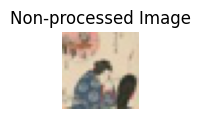

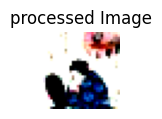

In [ ]:
import torchvision.transforms.functional as F

torch.manual_seed(RANDOM_SEED)
#visualize image (not processed)
cam_set = ArtBench10(root='./data', train=True, download=True, transform=transforms.ToTensor())
cam_loader = torch.utils.data.DataLoader(cam_set, batch_size=BATCH_SIZE,
                                          shuffle=True,)
data_iter = iter(cam_loader)
first_batch = next(data_iter)
first_image, first_label = first_batch
first_image = first_image[44]

print("first label", first_label[44])
print("first label maps to ", classes[8])
#visualize image (NOT processed)
img_grid = torchvision.utils.make_grid(first_image)

# Convert the grid to a numpy image
img_grid_np = img_grid.numpy().transpose((1, 2, 0))

# Visualize the images
plt.figure(figsize=(1,1))
plt.imshow(img_grid_np)
plt.title('Non-processed Image')
plt.axis('off')
plt.show()

#visualize the image (processed)
transformed_image = transform_train(F.to_pil_image(first_image))
img_grid = torchvision.utils.make_grid(transformed_image)

# Convert the grid to a numpy image
img_grid_np = img_grid.numpy().transpose((1, 2, 0))

# Visualize the images
plt.figure(figsize=(1,1))
plt.imshow(img_grid_np)
plt.title('processed Image')
plt.axis('off')
plt.show()

In [ ]:
cam_model = WideResNet(LAYERS, CLASS_NUM, WIDE,
                   droprate=DROPOUT,
                   use_bn=BATCHNORM,
                   use_fixup=FIXUP)
cam_model = cam_model.cuda()

cam_model_path = '/content/drive/MyDrive/checkpoints/checkpoint_epoch_110.pth'
cam_checkpoint = torch.load(cam_model_path)

# Load the state dictionary into the model
cam_model.load_state_dict(cam_checkpoint['model_state_dict'])
cam_model.cuda()
cam_model.eval()

# Initialize CAM object
cam_extractor = CAM(cam_model)

input_image = transformed_image.cuda()  # Replace with an actual input image tensor
output = cam_model(input_image.unsqueeze(0))
class_idx = torch.argmax(output).item()  # Get predicted class

# Compute CAM
cam_output = cam_extractor.compute_cam(class_idx)

# Clear hooks to free memory
cam_extractor.clear_hooks()


Unfortunately, the CAM analysis isn't working at this point in time

#PCA analysis

determine number of components to keep

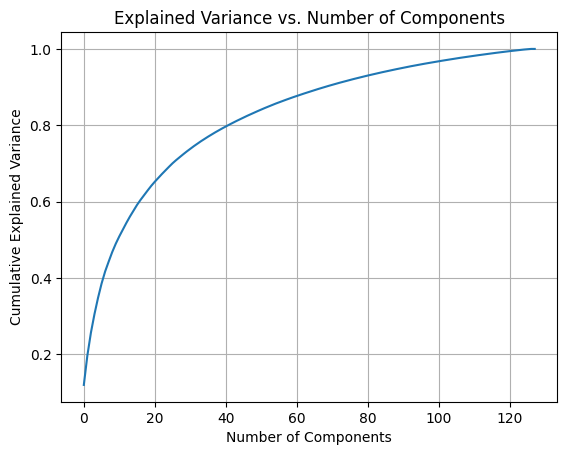

Number of components to keep for 95.0% explained variance: 91


In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

feature_map_dir = '/content/drive/MyDrive/feature_maps_with_labels/'

# Step 1: Load the saved feature map using torch.load
# Replace 'feature_map.pth' with the actual file path to your saved feature map
feature_file = 'feature_maps3_epoch_5.pth'
feature_path = feature_map_dir + feature_file
feature_map_dict = torch.load(feature_path)
feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Ensure the feature_map is on CPU and detached from gradients
feature_map = feature_map.cpu().detach()

# Reshape the feature maps into a 2D matrix
num_samples, num_channels, height, width = feature_map.shape
X = feature_map.view(num_samples, -1).numpy()

# Initialize PCA
pca = PCA()

# Fit PCA to the data
pca.fit(X)

# Plot explained variance ratio to decide the number of components to keep
import matplotlib.pyplot as plt

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.plot(cumulative_variance_ratio)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Determine the number of components to keep
threshold_variance = 0.95  # Set your desired explained variance threshold
num_components_to_keep = np.argmax(cumulative_variance_ratio >= threshold_variance) + 1

print(f"Number of components to keep for {threshold_variance*100}% explained variance: {num_components_to_keep}")


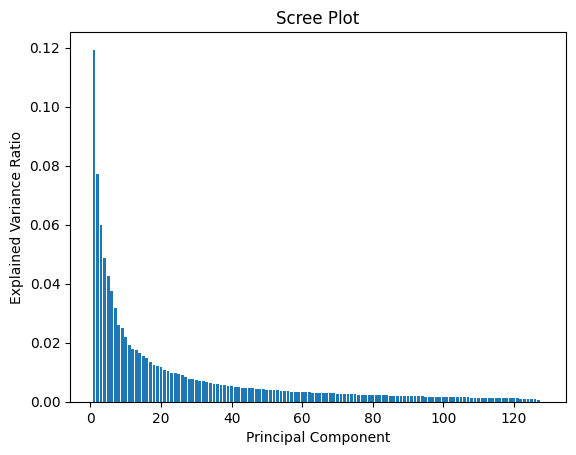

In [ ]:
# SCREE Plot the explained variance for each component
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

Tried using 91 (as per top graph), but it seemed very redundant, so kept it at 20

Get PCA for beginning of training

In [ ]:
num_components = 20  # Set the number of components you want to keep

<ipython-input-178-0147cf2b315e>:40: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-178-0147cf2b315e>:44: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



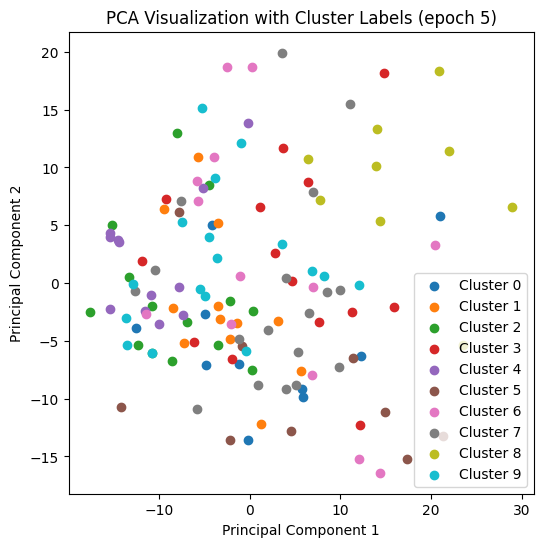

<ipython-input-178-0147cf2b315e>:84: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-178-0147cf2b315e>:88: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



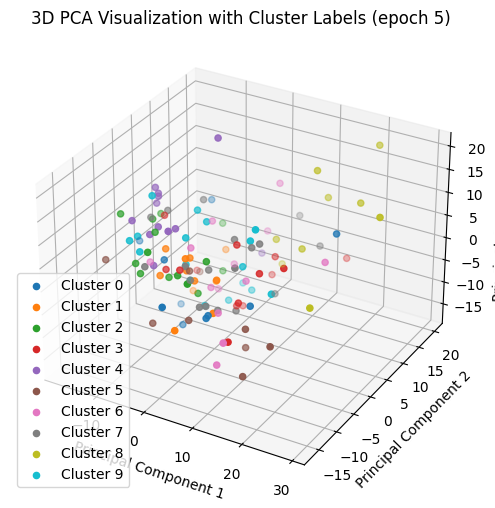

In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

feature_map_dir = '/content/drive/MyDrive/feature_maps_with_labels/'

# Step 1: Load the saved feature map using torch.load
# Replace 'feature_map.pth' with the actual file path to your saved feature map
feature_file = 'feature_maps3_epoch_5.pth'
feature_path = feature_map_dir + feature_file
feature_map_dict = torch.load(feature_path)
feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Ensure the feature_map is on CPU and detached from gradients
feature_map = feature_map.cpu().detach()

# Step 2: Convert the PyTorch tensor to a NumPy array
feature_map_np = feature_map.numpy()

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Step 4: Perform PCA on the feature map
pca = PCA(n_components=num_components)
feature_map_pca = pca.fit_transform(feature_map_np)

# Convert feature_map_labels to a NumPy array on the CPU
feature_map_labels = feature_map_labels.cpu().numpy()

# Now, feature_map_pca contains the PCA-transformed feature map with reduced dimensions.
plt.figure(figsize=(6, 6))

# Define a colormap for your labels
colormap = plt.cm.get_cmap('viridis', len(set(feature_map_labels)))  # Adjust 'viridis' to your preferred colormap

# Scatter plot each point with a color corresponding to its label
for label in set(feature_map_labels):
    plt.scatter(feature_map_pca[feature_map_labels == label, 0], feature_map_pca[feature_map_labels == label, 1],
                label=f'Cluster {label}', cmap=colormap)

# Add labels and a legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.title('PCA Visualization with Cluster Labels (epoch 5)')
plt.show()

import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Import 3D plotting

feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Step 4: Perform PCA on the feature map
pca = PCA(n_components=num_components)
feature_map_pca = pca.fit_transform(feature_map_np)

# Convert feature_map_labels to a NumPy array on the CPU
feature_map_labels = feature_map_labels.cpu().numpy()

# Now, feature_map_pca contains the PCA-transformed feature map with reduced dimensions.
plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')  # Create a 3D axes

# Define a colormap for your labels
colormap = plt.cm.get_cmap('viridis', len(set(feature_map_labels)))  # Adjust 'viridis' to your preferred colormap

# Scatter plot each point with a color corresponding to its label
for label in set(feature_map_labels):
    ax.scatter(feature_map_pca[feature_map_labels == label, 0],
               feature_map_pca[feature_map_labels == label, 1],
               feature_map_pca[feature_map_labels == label, 2],
               label=f'Cluster {label}', cmap=colormap)

# Add labels and a legend
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend()

# Show the plot
plt.title('3D PCA Visualization with Cluster Labels (epoch 5)')
plt.show()


Get PCA for middle of Training (epochs 30, 60, 85)

<ipython-input-179-8e689bed124f>:35: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-179-8e689bed124f>:39: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



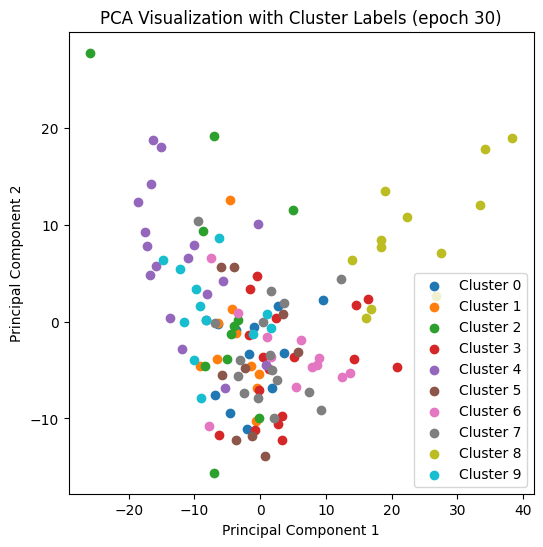

<ipython-input-179-8e689bed124f>:75: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-179-8e689bed124f>:79: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



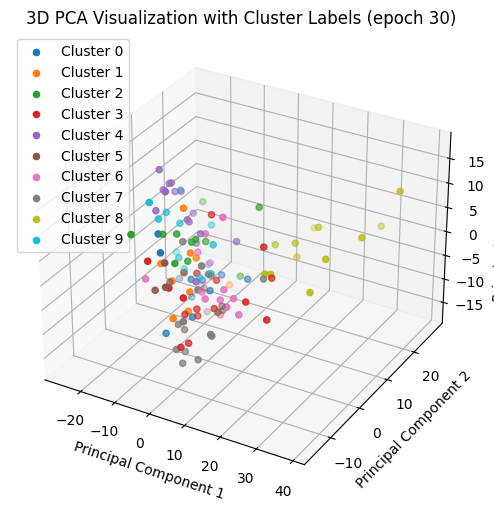

In [ ]:
feature_map_dir = '/content/drive/MyDrive/feature_maps_with_labels/'

# Step 1: Load the saved feature map using torch.load
# Replace 'feature_map.pth' with the actual file path to your saved feature map
feature_file = 'feature_maps3_epoch_30.pth'
feature_path = feature_map_dir + feature_file
feature_map_dict = torch.load(feature_path)
feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Ensure the feature_map is on CPU and detached from gradients
feature_map = feature_map.cpu().detach()

# Step 2: Convert the PyTorch tensor to a NumPy array
feature_map_np = feature_map.numpy()

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Step 4: Perform PCA on the feature map
pca = PCA(n_components=num_components)
feature_map_pca = pca.fit_transform(feature_map_np)

# Convert feature_map_labels to a NumPy array on the CPU
feature_map_labels = feature_map_labels.cpu().numpy()

# Now, feature_map_pca contains the PCA-transformed feature map with reduced dimensions.
plt.figure(figsize=(6, 6))

# Define a colormap for your labels
colormap = plt.cm.get_cmap('viridis', len(set(feature_map_labels)))  # Adjust 'viridis' to your preferred colormap

# Scatter plot each point with a color corresponding to its label
for label in set(feature_map_labels):
    plt.scatter(feature_map_pca[feature_map_labels == label, 0], feature_map_pca[feature_map_labels == label, 1],
                label=f'Cluster {label}', cmap=colormap)

# Add labels and a legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.title('PCA Visualization with Cluster Labels (epoch 30)')
plt.show()

### 3D PLOTTING ####

feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Step 4: Perform PCA on the feature map
pca = PCA(n_components=num_components)
feature_map_pca = pca.fit_transform(feature_map_np)

# Convert feature_map_labels to a NumPy array on the CPU
feature_map_labels = feature_map_labels.cpu().numpy()

# Now, feature_map_pca contains the PCA-transformed feature map with reduced dimensions.
plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')  # Create a 3D axes

# Define a colormap for your labels
colormap = plt.cm.get_cmap('viridis', len(set(feature_map_labels)))  # Adjust 'viridis' to your preferred colormap

# Scatter plot each point with a color corresponding to its label
for label in set(feature_map_labels):
    ax.scatter(feature_map_pca[feature_map_labels == label, 0],
               feature_map_pca[feature_map_labels == label, 1],
               feature_map_pca[feature_map_labels == label, 2],
               label=f'Cluster {label}', cmap=colormap)

# Add labels and a legend
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend()

# Show the plot
plt.title('3D PCA Visualization with Cluster Labels (epoch 30)')
plt.show()


<ipython-input-180-4e4b0f04b660>:35: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-180-4e4b0f04b660>:39: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



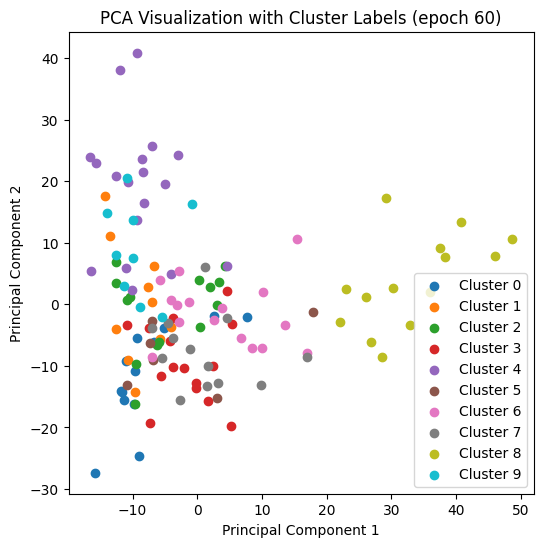

<ipython-input-180-4e4b0f04b660>:75: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-180-4e4b0f04b660>:79: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



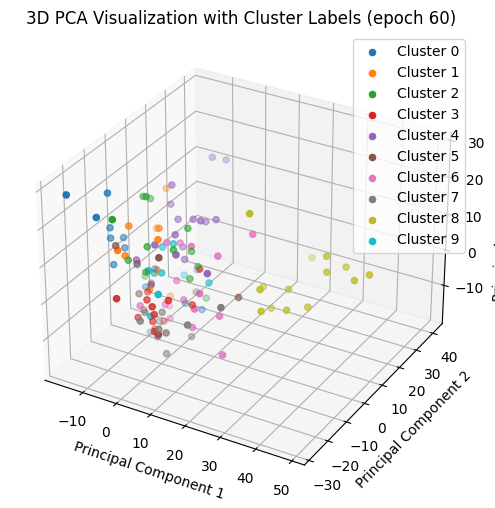

In [ ]:
feature_map_dir = '/content/drive/MyDrive/feature_maps_with_labels/'

# Step 1: Load the saved feature map using torch.load
# Replace 'feature_map.pth' with the actual file path to your saved feature map
feature_file = 'feature_maps3_epoch_60.pth'
feature_path = feature_map_dir + feature_file
feature_map_dict = torch.load(feature_path)
feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Ensure the feature_map is on CPU and detached from gradients
feature_map = feature_map.cpu().detach()

# Step 2: Convert the PyTorch tensor to a NumPy array
feature_map_np = feature_map.numpy()

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Step 4: Perform PCA on the feature map
pca = PCA(n_components=num_components)
feature_map_pca = pca.fit_transform(feature_map_np)

# Convert feature_map_labels to a NumPy array on the CPU
feature_map_labels = feature_map_labels.cpu().numpy()

# Now, feature_map_pca contains the PCA-transformed feature map with reduced dimensions.
plt.figure(figsize=(6, 6))

# Define a colormap for your labels
colormap = plt.cm.get_cmap('viridis', len(set(feature_map_labels)))  # Adjust 'viridis' to your preferred colormap

# Scatter plot each point with a color corresponding to its label
for label in set(feature_map_labels):
    plt.scatter(feature_map_pca[feature_map_labels == label, 0], feature_map_pca[feature_map_labels == label, 1],
                label=f'Cluster {label}', cmap=colormap)

# Add labels and a legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.title('PCA Visualization with Cluster Labels (epoch 60)')
plt.show()

### 3D PLOTTING ####

feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Step 4: Perform PCA on the feature map
pca = PCA(n_components=num_components)
feature_map_pca = pca.fit_transform(feature_map_np)

# Convert feature_map_labels to a NumPy array on the CPU
feature_map_labels = feature_map_labels.cpu().numpy()

# Now, feature_map_pca contains the PCA-transformed feature map with reduced dimensions.
plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')  # Create a 3D axes

# Define a colormap for your labels
colormap = plt.cm.get_cmap('viridis', len(set(feature_map_labels)))  # Adjust 'viridis' to your preferred colormap

# Scatter plot each point with a color corresponding to its label
for label in set(feature_map_labels):
    ax.scatter(feature_map_pca[feature_map_labels == label, 0],
               feature_map_pca[feature_map_labels == label, 1],
               feature_map_pca[feature_map_labels == label, 2],
               label=f'Cluster {label}', cmap=colormap)

# Add labels and a legend
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend()

# Show the plot
plt.title('3D PCA Visualization with Cluster Labels (epoch 60)')
plt.show()


<ipython-input-181-2fb9d28d7841>:35: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-181-2fb9d28d7841>:39: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



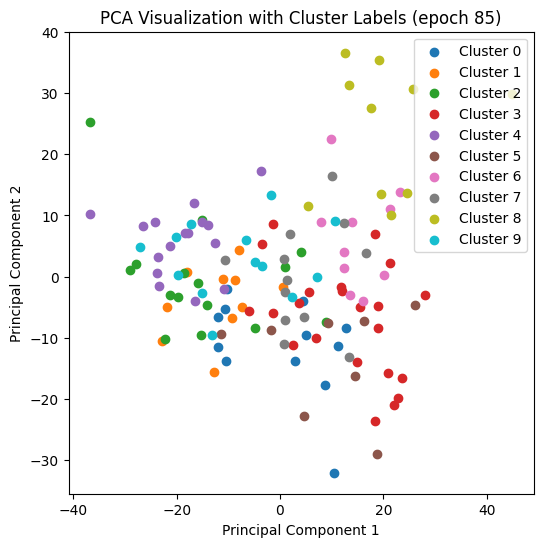

<ipython-input-181-2fb9d28d7841>:75: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-181-2fb9d28d7841>:79: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



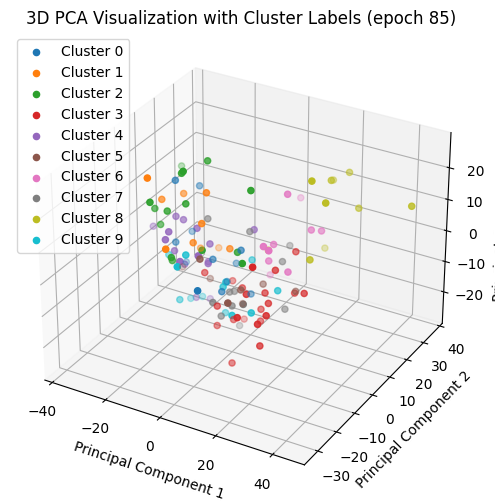

In [ ]:
feature_map_dir = '/content/drive/MyDrive/feature_maps_with_labels/'

# Step 1: Load the saved feature map using torch.load
# Replace 'feature_map.pth' with the actual file path to your saved feature map
feature_file = 'feature_maps3_epoch_85.pth'
feature_path = feature_map_dir + feature_file
feature_map_dict = torch.load(feature_path)
feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Ensure the feature_map is on CPU and detached from gradients
feature_map = feature_map.cpu().detach()

# Step 2: Convert the PyTorch tensor to a NumPy array
feature_map_np = feature_map.numpy()

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Step 4: Perform PCA on the feature map
pca = PCA(n_components=num_components)
feature_map_pca = pca.fit_transform(feature_map_np)

# Convert feature_map_labels to a NumPy array on the CPU
feature_map_labels = feature_map_labels.cpu().numpy()

# Now, feature_map_pca contains the PCA-transformed feature map with reduced dimensions.
plt.figure(figsize=(6, 6))

# Define a colormap for your labels
colormap = plt.cm.get_cmap('viridis', len(set(feature_map_labels)))  # Adjust 'viridis' to your preferred colormap

# Scatter plot each point with a color corresponding to its label
for label in set(feature_map_labels):
    plt.scatter(feature_map_pca[feature_map_labels == label, 0], feature_map_pca[feature_map_labels == label, 1],
                label=f'Cluster {label}', cmap=colormap)

# Add labels and a legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.title('PCA Visualization with Cluster Labels (epoch 85)')
plt.show()

### 3D PLOTTING ####

feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Step 4: Perform PCA on the feature map
pca = PCA(n_components=num_components)
feature_map_pca = pca.fit_transform(feature_map_np)

# Convert feature_map_labels to a NumPy array on the CPU
feature_map_labels = feature_map_labels.cpu().numpy()

# Now, feature_map_pca contains the PCA-transformed feature map with reduced dimensions.
plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')  # Create a 3D axes

# Define a colormap for your labels
colormap = plt.cm.get_cmap('viridis', len(set(feature_map_labels)))  # Adjust 'viridis' to your preferred colormap

# Scatter plot each point with a color corresponding to its label
for label in set(feature_map_labels):
    ax.scatter(feature_map_pca[feature_map_labels == label, 0],
               feature_map_pca[feature_map_labels == label, 1],
               feature_map_pca[feature_map_labels == label, 2],
               label=f'Cluster {label}', cmap=colormap)

# Add labels and a legend
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend()

# Show the plot
plt.title('3D PCA Visualization with Cluster Labels (epoch 85)')
plt.show()


Get PCA for end of Training

<ipython-input-182-9368d67b6979>:35: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-182-9368d67b6979>:39: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



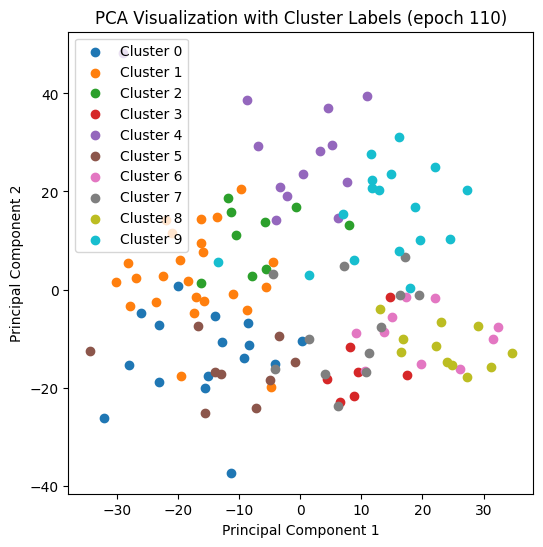

<ipython-input-182-9368d67b6979>:75: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.

<ipython-input-182-9368d67b6979>:79: UserWarning:

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored



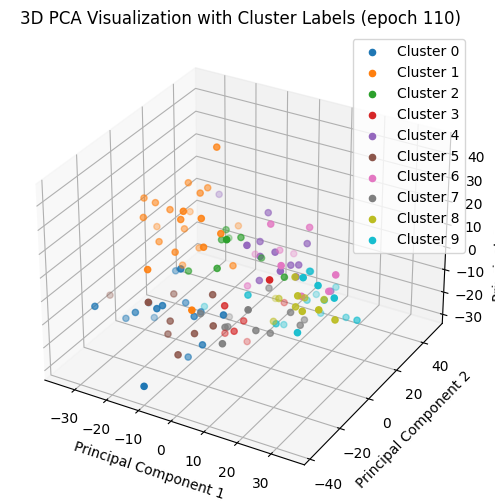

In [ ]:
feature_map_dir = '/content/drive/MyDrive/feature_maps_with_labels/'

# Step 1: Load the saved feature map using torch.load
# Replace 'feature_map.pth' with the actual file path to your saved feature map
feature_file = 'feature_maps3_epoch_110.pth'
feature_path = feature_map_dir + feature_file
feature_map_dict = torch.load(feature_path)
feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Ensure the feature_map is on CPU and detached from gradients
feature_map = feature_map.cpu().detach()

# Step 2: Convert the PyTorch tensor to a NumPy array
feature_map_np = feature_map.numpy()

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Step 4: Perform PCA on the feature map
pca = PCA(n_components=num_components)
feature_map_pca = pca.fit_transform(feature_map_np)

# Convert feature_map_labels to a NumPy array on the CPU
feature_map_labels = feature_map_labels.cpu().numpy()

# Now, feature_map_pca contains the PCA-transformed feature map with reduced dimensions.
plt.figure(figsize=(6, 6))

# Define a colormap for your labels
colormap = plt.cm.get_cmap('viridis', len(set(feature_map_labels)))  # Adjust 'viridis' to your preferred colormap

# Scatter plot each point with a color corresponding to its label
for label in set(feature_map_labels):
    plt.scatter(feature_map_pca[feature_map_labels == label, 0], feature_map_pca[feature_map_labels == label, 1],
                label=f'Cluster {label}', cmap=colormap)

# Add labels and a legend
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.title('PCA Visualization with Cluster Labels (epoch 110)')
plt.show()

### 3D PLOTTING ####

feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Step 4: Perform PCA on the feature map
pca = PCA(n_components=num_components)
feature_map_pca = pca.fit_transform(feature_map_np)

# Convert feature_map_labels to a NumPy array on the CPU
feature_map_labels = feature_map_labels.cpu().numpy()

# Now, feature_map_pca contains the PCA-transformed feature map with reduced dimensions.
plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')  # Create a 3D axes

# Define a colormap for your labels
colormap = plt.cm.get_cmap('viridis', len(set(feature_map_labels)))  # Adjust 'viridis' to your preferred colormap

# Scatter plot each point with a color corresponding to its label
for label in set(feature_map_labels):
    ax.scatter(feature_map_pca[feature_map_labels == label, 0],
               feature_map_pca[feature_map_labels == label, 1],
               feature_map_pca[feature_map_labels == label, 2],
               label=f'Cluster {label}', cmap=colormap)

# Add labels and a legend
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.legend()

# Show the plot
plt.title('3D PCA Visualization with Cluster Labels (epoch 110)')
plt.show()


In [ ]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import plotly.express as px

feature_map_dir = '/content/drive/MyDrive/feature_maps_with_labels/'

# Step 1: Load the saved feature map using torch.load
# Replace 'feature_map.pth' with the actual file path to your saved feature map
feature_file = 'feature_maps3_epoch_110.pth'
feature_path = feature_map_dir + feature_file
feature_map_dict = torch.load(feature_path)
feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Ensure the feature_map is on CPU and detached from gradients
feature_map = feature_map.cpu().detach()

# Step 2: Convert the PyTorch tensor to a NumPy array
feature_map_np = feature_map.numpy()

num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Step 4: Perform PCA on the feature map
pca = PCA(n_components=num_components)
feature_map_pca = pca.fit_transform(feature_map_np)

# Convert feature_map_labels to a NumPy array on the CPU
feature_map_labels = feature_map_labels.cpu().numpy()

# Create a DataFrame for Plotly
import pandas as pd
df = pd.DataFrame({
    'PC1': feature_map_pca[:, 0],
    'PC2': feature_map_pca[:, 1],
    'PC3': feature_map_pca[:, 2],
    'Labels': feature_map_labels
})

# Create an interactive 3D scatter plot using Plotly
fig = px.scatter_3d(df, x='PC1', y='PC2', z='PC3', color='Labels', title='Interactive 3D PCA Visualization')
fig.show()


#TSNE Analysis

get tsne for first saved epoch

In [ ]:
from sklearn.manifold import TSNE

feature_map_dir = '/content/drive/MyDrive/feature_maps_with_labels/'

# Step 1: Load the saved feature map using torch.load
# Replace 'feature_map.pth' with the actual file path to your saved feature map
feature_file = 'feature_maps3_epoch_5.pth'
feature_path = feature_map_dir + feature_file
feature_map_dict = torch.load(feature_path,map_location=torch.device('cpu'))
feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Ensure the feature_map is on CPU and detached from gradients
feature_map = feature_map.cpu().detach()

# Step 2: Convert the PyTorch tensor to a NumPy array
feature_map_np = feature_map.numpy()

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Set the parameters
tsne = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42)

# Fit and transform the standardized data
X_tsne = tsne.fit_transform(feature_map_np)


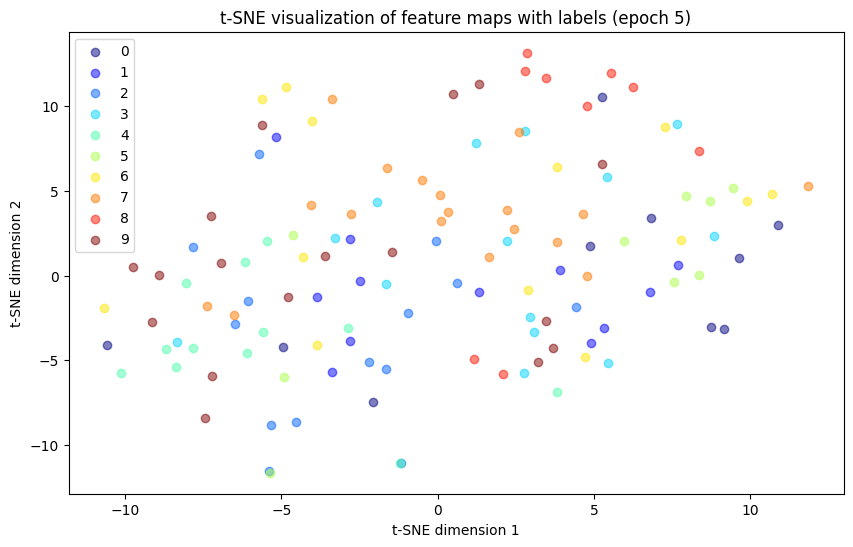

In [ ]:
import matplotlib.pyplot as plt

feature_map_labels_np = feature_map_labels.cpu().numpy().tolist()

labels = feature_map_labels_np

# Create a scatter plot with colors based on labels
unique_labels = list(set(labels))
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(10, 6))
for i, label in enumerate(unique_labels):
    idxs = [idx for idx, val in enumerate(labels) if val == label]
    plt.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1], color=colors[i], alpha=0.5, label=label)

plt.title('t-SNE visualization of feature maps with labels (epoch 5)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend()
plt.show()

get tsne for middle layers

In [ ]:
from sklearn.manifold import TSNE

feature_map_dir = '/content/drive/MyDrive/feature_maps_with_labels/'

# Step 1: Load the saved feature map using torch.load
# Replace 'feature_map.pth' with the actual file path to your saved feature map
feature_file = 'feature_maps3_epoch_30.pth'
feature_path = feature_map_dir + feature_file
feature_map_dict = torch.load(feature_path,map_location=torch.device('cpu'))
feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Ensure the feature_map is on CPU and detached from gradients
feature_map = feature_map.cpu().detach()

# Step 2: Convert the PyTorch tensor to a NumPy array
feature_map_np = feature_map.numpy()

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Set the parameters
tsne = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42)

# Fit and transform the standardized data
X_tsne = tsne.fit_transform(feature_map_np)


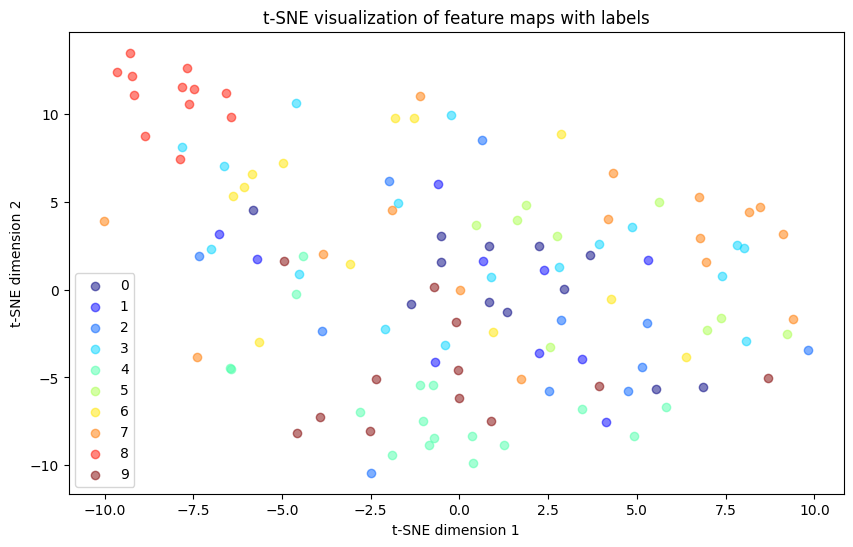

In [ ]:
import matplotlib.pyplot as plt

feature_map_labels_np = feature_map_labels.cpu().numpy().tolist()

labels = feature_map_labels_np

# Create a scatter plot with colors based on labels
unique_labels = list(set(labels))
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(10, 6))
for i, label in enumerate(unique_labels):
    idxs = [idx for idx, val in enumerate(labels) if val == label]
    plt.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1], color=colors[i], alpha=0.5, label=label)

plt.title('t-SNE visualization of feature maps with labels')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend()
plt.show()

tsne for epoch 60

In [ ]:
from sklearn.manifold import TSNE

feature_map_dir = '/content/drive/MyDrive/feature_maps_with_labels/'

# Step 1: Load the saved feature map using torch.load
# Replace 'feature_map.pth' with the actual file path to your saved feature map
feature_file = 'feature_maps3_epoch_60.pth'
feature_path = feature_map_dir + feature_file
feature_map_dict = torch.load(feature_path,map_location=torch.device('cpu'))
feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Ensure the feature_map is on CPU and detached from gradients
feature_map = feature_map.cpu().detach()

# Step 2: Convert the PyTorch tensor to a NumPy array
feature_map_np = feature_map.numpy()

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Set the parameters
tsne = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42)

# Fit and transform the standardized data
X_tsne = tsne.fit_transform(feature_map_np)


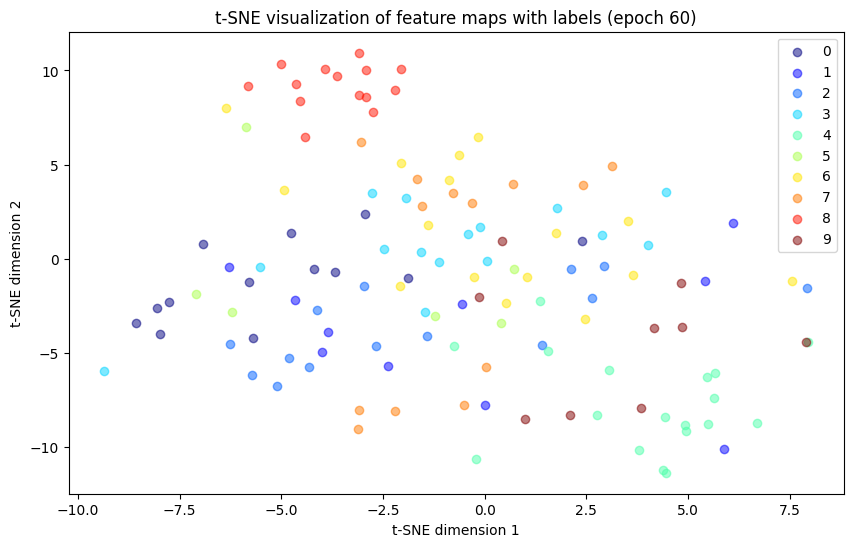

In [ ]:
import matplotlib.pyplot as plt

feature_map_labels_np = feature_map_labels.cpu().numpy().tolist()

labels = feature_map_labels_np

# Create a scatter plot with colors based on labels
unique_labels = list(set(labels))
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(10, 6))
for i, label in enumerate(unique_labels):
    idxs = [idx for idx, val in enumerate(labels) if val == label]
    plt.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1], color=colors[i], alpha=0.5, label=label)

plt.title('t-SNE visualization of feature maps with labels (epoch 60)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend()
plt.show()

epoch 80

In [ ]:
from sklearn.manifold import TSNE

feature_map_dir = '/content/drive/MyDrive/feature_maps_with_labels/'

# Step 1: Load the saved feature map using torch.load
# Replace 'feature_map.pth' with the actual file path to your saved feature map
feature_file = 'feature_maps3_epoch_80.pth'
feature_path = feature_map_dir + feature_file
feature_map_dict = torch.load(feature_path,map_location=torch.device('cpu'))
feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Ensure the feature_map is on CPU and detached from gradients
feature_map = feature_map.cpu().detach()

# Step 2: Convert the PyTorch tensor to a NumPy array
feature_map_np = feature_map.numpy()

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Set the parameters
tsne = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42)

# Fit and transform the standardized data
X_tsne = tsne.fit_transform(feature_map_np)


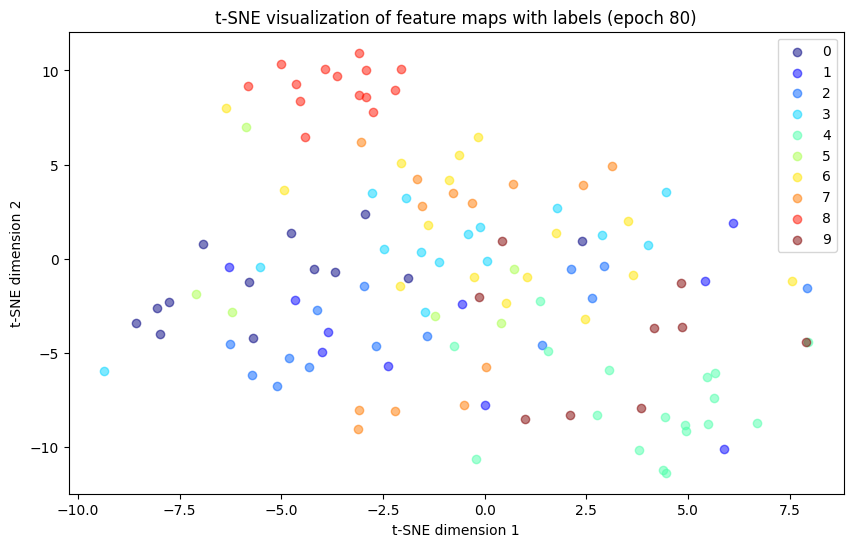

In [ ]:
import matplotlib.pyplot as plt

feature_map_labels_np = feature_map_labels.cpu().numpy().tolist()

labels = feature_map_labels_np

# Create a scatter plot with colors based on labels
unique_labels = list(set(labels))
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(10, 6))
for i, label in enumerate(unique_labels):
    idxs = [idx for idx, val in enumerate(labels) if val == label]
    plt.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1], color=colors[i], alpha=0.5, label=label)

plt.title('t-SNE visualization of feature maps with labels (epoch 80)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend()
plt.show()

Get tsne for last layer

In [ ]:
from sklearn.manifold import TSNE

feature_map_dir = '/content/drive/MyDrive/feature_maps_with_labels/'

# Step 1: Load the saved feature map using torch.load
# Replace 'feature_map.pth' with the actual file path to your saved feature map
feature_file = 'feature_maps3_epoch_110.pth'
feature_path = feature_map_dir + feature_file
feature_map_dict = torch.load(feature_path,map_location=torch.device('cpu'))
feature_map_labels = feature_map_dict['labels']
feature_map = feature_map_dict['feature_map']

# Ensure the feature_map is on CPU and detached from gradients
feature_map = feature_map.cpu().detach()

# Step 2: Convert the PyTorch tensor to a NumPy array
feature_map_np = feature_map.numpy()

# Step 3: Reshape the feature map if necessary
# Depending on how the feature map was saved, you might need to reshape it.
# If it's already in the desired shape, you can skip this step.
# Example: Reshape a 4D tensor (batch_size, channels, height, width) to 2D (num_samples, num_features)
num_samples, num_features = feature_map_np.shape[0], np.prod(feature_map_np.shape[1:])
feature_map_np = feature_map_np.reshape(num_samples, num_features)

# Set the parameters
tsne = TSNE(n_components=2, perplexity=20, n_iter=500, random_state=42)

# Fit and transform the standardized data
X_tsne = tsne.fit_transform(feature_map_np)


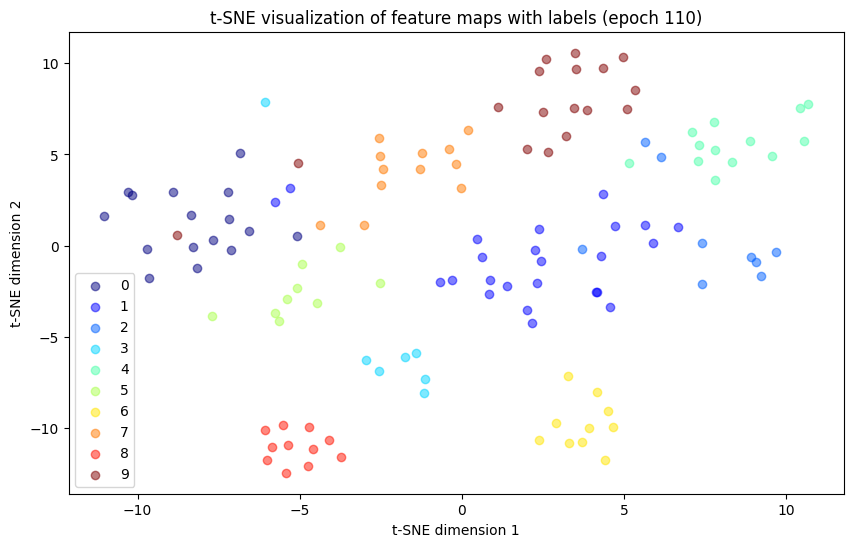

In [ ]:
import matplotlib.pyplot as plt

feature_map_labels_np = feature_map_labels.cpu().numpy().tolist()

labels = feature_map_labels_np

# Create a scatter plot with colors based on labels
unique_labels = list(set(labels))
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))

plt.figure(figsize=(10, 6))
for i, label in enumerate(unique_labels):
    idxs = [idx for idx, val in enumerate(labels) if val == label]
    plt.scatter(X_tsne[idxs, 0], X_tsne[idxs, 1], color=colors[i], alpha=0.5, label=label)

plt.title('t-SNE visualization of feature maps with labels (epoch 110)')
plt.xlabel('t-SNE dimension 1')
plt.ylabel('t-SNE dimension 2')
plt.legend()
plt.show()